In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
!mkdir dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/temp/roi_dataset.zip -d /

Archive:  /content/drive/MyDrive/temp/roi_dataset.zip
   creating: /content/split_roi_dataset/
   creating: /content/split_roi_dataset/test/
   creating: /content/split_roi_dataset/test/Pneumonia-Viral/
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (708).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (525).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (774).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (581).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (936).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1527).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1563).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1502).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (555)

In [7]:
from tensorflow.keras.applications import EfficientNetB0

def create_model():
    # Load EfficientNetB0 with pretrained weights
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Unfreeze layers for fine-tuning
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense layers
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def setup_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.15,
        brightness_range=[0.8,1.2],
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0/255)

    # Use the same paths for both normal and pywaveletted
    train_dir = '/content/split_roi_dataset/train'
    val_dir = '/content/split_roi_dataset/val'
    test_dir = '/content/split_roi_dataset/test'

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

def train_model(model, train_generator, validation_generator):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_resnet50_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=callbacks,
        verbose=1
    )

    return history

def evaluate_model(model, test_generator):
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=class_labels
    ))

In [8]:
# Create and run everything
model = create_model()
train_generator, validation_generator, test_generator = setup_data_generators()

Found 3966 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [9]:
history = train_model(model, train_generator, validation_generator)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5067 - loss: 1.4127
Epoch 1: val_accuracy improved from -inf to 0.33401, saving model to best_resnet50_model.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.5071 - loss: 1.4117 - val_accuracy: 0.3340 - val_loss: 1.3446 - learning_rate: 1.0000e-04
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6306 - loss: 1.0275
Epoch 2: val_accuracy did not improve from 0.33401
124/124 ━━━━━━━━━━━━━━━━━━━━ 128s 558ms/step - accuracy: 0.6306 - loss: 1.0277 - val_accuracy: 0.3340 - val_loss: 1.4739 - learning_rate: 1.0000e-04
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6482 - loss: 0.9225
Epoch 3: val_accuracy improved from 0.33401 to 0.33603, saving model to best_resnet50_model.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 533ms/step - accuracy: 0.6482 - loss: 0.9227 - val_accuracy: 0.3360 - val_loss: 1.4757 - learning_rate: 1.0000e-04
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.7804 - loss: 0.4492
Test accuracy: 76.55%
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step


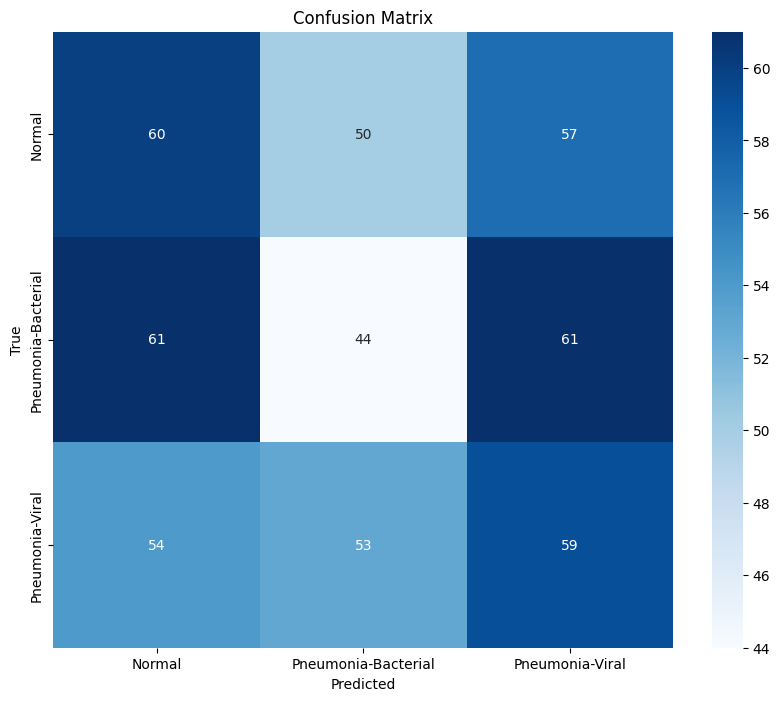


Classification Report:
                     precision    recall  f1-score   support

             Normal       0.34      0.36      0.35       167
Pneumonia-Bacterial       0.30      0.27      0.28       166
    Pneumonia-Viral       0.33      0.36      0.34       166

           accuracy                           0.33       499
          macro avg       0.33      0.33      0.33       499
       weighted avg       0.33      0.33      0.33       499



In [10]:
# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
evaluate_model(model, test_generator)